# Implementation verification: Toxicokinetics

In [34]:
using Revise
@time using DEBBase
using DataFrames
using BenchmarkTools
using Plots, StatsPlots, Plots.Measures
default(leg = false, lw = 1.5, titlefontsize = 10)

  0.001499 seconds (456 allocations: 30.617 KiB)

## Simulating TK for a single stressor

In [53]:
C_W_vec = 10 .^ range(log10(0.1), log10(2), 5) |> x -> round.(x, sigdigits = 2)
k_D_vec = 10 .^ range(log10(0.01), log10(1.0), 5) |> x -> round.(x, sigdigits = 2)

5-element Vector{Float64}:
 0.01
 0.032
 0.1
 0.32
 1.0

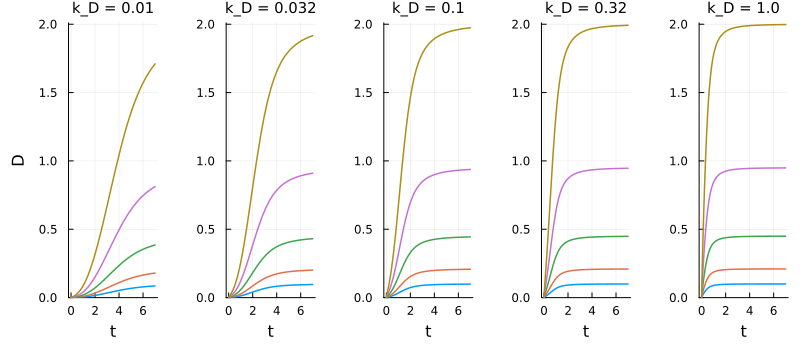

In [54]:
p = plot(
    layout = (1,length(k_D_vec)), 
    title = hcat(["k_D = $(k_D)" for k_D in unique(k_D_vec)]...),
    xlabel = "t",
    ylabel = ["D" "" "" "" ""],
    size = (800,350), 
    bottommargin = 5mm,
    leftmargin = 5mm, 
    ylim = (0, 2.01)
    )

for (i,k_D) in enumerate(k_D_vec)
    for C_W in C_W_vec

        glb = GlobalBaseParams(C_W = [C_W], t_max = 7)
        deb = DEBBaseParams(
            k_D = Matrix(hcat(repeat([k_D], 5))')
            )
        out = simulator(glb, deb)

        @df out plot!(p, :t, :D_G, subplot = i)
    end
end
display(p)

## Varying the number of stressors

In [63]:
using DEBBase

In [64]:
glb = GlobalBaseParams(C_W = [1., 1.], t_max = 7)
deb = DEBBaseParams(
    k_D = Matrix(hcat(repeat([], 5))')
    )
out = simulator(glb, deb)

AssertionError: AssertionError: Number of rows in deb.k_D (0) has to match number of stressors indicated in glb.C_W (2)

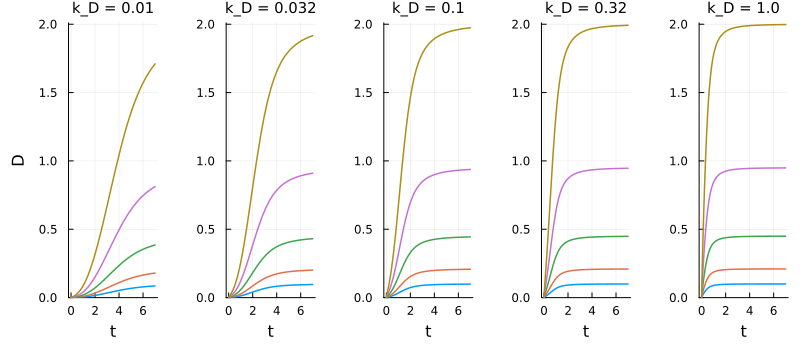

In [55]:
p = plot(
    layout = (1,length(k_D_vec)), 
    title = hcat(["k_D = $(k_D)" for k_D in unique(k_D_vec)]...),
    xlabel = "t",
    ylabel = ["D" "" "" "" ""],
    size = (800,350), 
    bottommargin = 5mm,
    leftmargin = 5mm, 
    ylim = (0, 2.01)
    )

for (i,k_D) in enumerate(k_D_vec)
    for C_W in C_W_vec

        glb = GlobalBaseParams(C_W = [C_W, C_W], t_max = 7)
        deb = DEBBaseParams(
            k_D = Matrix(hcat(repeat([k_D], 5))')
            )
        out = simulator(glb, deb)

        @df out plot!(p, :t, :D_G, subplot = i)
    end
end
display(p)

## Varying coupled TK parameter

## Uncoupling the TK parameter

## Modifying the model: Simplified TK

We start by having a look at the predefined TK function:

In [39]:
less(DEBBase.Ddot!)

function Ddot!(
    deb::AbstractParams,
    z::Int64; 
    C_W::Float64, 
    D::Float64, 
    S::Float64, 
    Sdot::Float64, 
    S_max::Float64
    )
    # surface area / volume ratio
    let AV_ratio = S^(2/3) / S, AV_max_ratio = S_max^(2/3) / S_max
        # TK with account for body size: smaller A/V ration = higher elimination rate, diluation by growth
        return deb.k_D[z] * (AV_max_ratio / AV_ratio) * (C_W[z] - D[z]) - D[z] * (Sdot/S)
    end
end

"""
Definition of reserveless DEB derivatives. 
$(TYPEDSIGNATURES)
"""
function DEB!(du, u, p, t)
    glb, deb = p
    # unpack scalar state variables
    X_p, X_emb, S, H, R = u

    C_W = u[glb.num_scalar_statevars+1:Int(glb.num_scalar_statevars+(length(u)-glb.num_scalar_statevars)/glb.num_vector_statevars)]
    D = u[Int(glb:num_scalar_statevars+1+length(C_W)):end]

    S = max(0, S) # control for negative values

    life_stage = determine_life_stage(deb; H = H, X_emb = X_emb)
    
    ddot 
    for (z,C_Wz) in enumerate(C_W)

In [30]:
function DEBBase.Ddot!()

end

In [45]:
less(DEBBaseParams())

MethodError: MethodError: no method matching DEBBaseParams()

In [47]:
[Float64, Int64]

2-element Vector{DataType}:
 Float64
 Int64

In [75]:
statevars = [:X_p, :X_emb, :S, :C_W]
sttypes = [Float64, Float64, Float64, Vector{Float64}]
u = [0.33, 2., 3., [4., 5., 314.]]

4-element Vector{Any}:
 0.33
 2.0
 3.0
  [4.0, 5.0, 314.0]

In [79]:
using DEBBase

In [81]:
DEBBase.@unpack u 

LoadError: LoadError: MethodError: no method matching var"@unpack"(::LineNumberNode, ::Module)

Closest candidates are:
  var"@unpack"(::LineNumberNode, ::Module, !Matched::Any)
   @ UnPack C:\Users\simon\.julia\packages\UnPack\EkESO\src\UnPack.jl:92

in expression starting at c:\Users\simon\Documents\Julia\DEBBase.jl\notebooks\ImplementationVerification\ImplemenationVerification_20231222_TK.ipynb:1

In [77]:
@unpack u

In [78]:
C_W

3-element Vector{Float64}:
   4.0
   5.0
 314.0

In [41]:
less(DEBBaseParams())

MethodError: MethodError: no method matching DEBBaseParams()